In [47]:
%pylab inline
data = open("dblp-small.txt",'r')
dlines =data.readlines()
#work with small subset for now
# dlines = dlines[:100]
all_words = []
for l in dlines:
    all_words.extend(l.split())
vocab = unique(all_words)
# Hyperparameters
K = 20 # number of topics
lmda = 0.9 #percentage of background 

Populating the interactive namespace from numpy and matplotlib


In [48]:
print len(dlines)
print len(all_words)
print len(vocab)

10835
1734168
30140


$\lambda$ specifies the percentage of the corpus that are generated from the background model.

let $\theta$ be a vector of topic distributions, where k=0 is the background model, and k+1...K is the real topics.

In [3]:
ndoc = len(dlines) #number of documents
np.random.seed(999)

In [94]:
def normalize(arr):
    #Normalize document topic probabilities
    normed_prob = []
    if sum(arr)!=0: # prevent div/0 nans
        for i in np.arange(len(arr)):
            normed_prob.append(arr[i]/sum(arr[i]))
        return np.array(normed_prob)
    else: # if the whole array is zero
        return np.array(arr)

#### 1)

In [5]:
# normed_document_topic_prob = document_topic_prob.T/np.sum(document_topic_prob,axis=1) #normalize across documents

In [86]:
#Random Initialization then normalize probabilities
document_topic_prob = np.random.rand(ndoc, K+1 )  # P(z|pi) (K+1 topics for background)
#Normalize document topic probabilities
document_topic_prob = normalize(document_topic_prob)
topic_word_prob = np.random.rand(K+1, len(vocab))# P(w | theta)
topic_word_prob = normalize(topic_word_prob)
#too large to do random.rand(ndoc, len(vocab), K+1) , so simply initialize with all zeroes 
topic_prob = np.random.rand(ndoc, len(vocab), K+1)# P(z | D,pi,theta)
topic_prob = normalize(topic_prob)

background_prob = np.random.rand(ndoc, len(vocab))# qy(y=1)=P(y=1| D,pi,theta)
background_prob = normalize(background_prob)

niter = 0
prev_loglikelihood =0
loglikelihood =999
loglikelihood_lst = []
while (abs(loglikelihood-prev_loglikelihood)>0.0001 or niter<=100): 
    print "Step #",niter+1
    # Compute log p(D|theta, pi) at the ith step 
    loglikelihood = 0
    for d in np.arange(len(dlines)):
        for w in np.arange(len(vocab)):
            loglikelihood+= log(lmda*background_prob[d,w]+(1-lmda)*sum(document_topic_prob[d,:]*topic_word_prob[:, w]))
    print "Log likelihood:",str(loglikelihood)
    if np.isnan(loglikelihood):
        loglikelihood=99999
    #matrix storing yij (if yij=0 then background; yij=1 then topic words)
    Y = np.zeros([ndoc, len(vocab)])
    print "Expectation Step "
    qzy=0
    qy=0
    for d, document in enumerate(dlines):
        for w in np.arange(len(vocab)):
            if Y[d][w]==1: 
                # If Topic
                qzy = document_topic_prob[d,:]*topic_word_prob[:, w]
                #Finish computing qzy
                qzy = normalize(prob)
                topic_prob[d][w] = qzy
            elif Y[d][w]==0: 
                # If Background, Computing q_y 
                numerator =0
                for k in np.arange(K):
                    numerator += sum(document_topic_prob[d,:]*topic_word_prob[:,w])
                #Finish computing qy
                numerator = (1-lmda)*numerator
                p_wD = document.count(str(w))/len(document)
                denominator = lmda*p_wD + numerator
                qy = numerator/denominator
                background_prob[d][w] = qy
#             print "qzy:",qzy
    print "Maximization step  "

    # update p(z=k|pi) for the n+1th step
    for z in np.arange(K):
        for w in np.arange(len(vocab)):    
            ndk=0
            for d in np.arange(len(dlines)):
                c = dlines[d].count(str(w)) #count of a word in the document 
                ndk += c*topic_prob[d,w,z]*background_prob[d,w]
            print ndk
            topic_word_prob[z][w]=ndk
        #Normalize across all documents for each topic 
        topic_word_prob[z] = normalize(topic_word_prob[z]) 
    # update p(w|theta_k) for the n+1th step
    for d in np.arange(len(dlines)):
        for z in np.arange(K):
            nwk=0
            for w in np.arange(len(vocab)):    
                c = dlines[d].count(str(w)) #count of a word in the document 
                nwk += c*topic_prob[d,w,z]*background_prob[d,w]
            document_topic_prob[d][z]=nwk
        #Normalize across all words in the document
        document_topic_prob[d] = normalize(document_topic_prob[d]) 
    #Update iteration and log-likelihood
    niter +=1
    loglikelihood_lst.append(loglikelihood)
    prev_loglikelihood = loglikelihood
print "Finished"

Step # 1
Log likelihood: -247355.422185
Expectation Step 
Maximization step  
Step # 2
Log likelihood: -213208.470581
Expectation Step 
Maximization step  
Step # 3
Log likelihood: -184789.600094
Expectation Step 
Maximization step  
Step # 4
Log likelihood: -155554.738783
Expectation Step 
Maximization step  
Step # 5
Log likelihood: -130234.976775
Expectation Step 
Maximization step  
Step # 6
Log likelihood: -102738.835667
Expectation Step 
Maximization step  
Step # 7
Log likelihood: -83722.5617673
Expectation Step 
Maximization step  
Step # 8
Log likelihood: -66651.7071653
Expectation Step 
Maximization step  
Step # 9
Log likelihood: -50215.4235258
Expectation Step 
Maximization step  
Step # 10
Log likelihood: -37014.6456225
Expectation Step 
Maximization step  
Step # 11
Log likelihood: -20819.6551882
Expectation Step 
Maximization step  
Step # 12
Log likelihood: -6468.23937051
Expectation Step 
Maximization step  
Step # 13
Log likelihood: 2558.36519447
Expectation Step 
Max

#### 2)  The value of the log likelihood should be monotonically increasing as each iteration progresses, but the amount of increase in loglikelihood should slowly plateau as the iteration progresses. (This is the motivation for using the  dL<0.0001 stopping criterion)

#### 3)  Since the log likelihood at the i-1 th step should be larger than the one in the i-th step, the numerator is a positive quantity (assuming that the log-likelihood is positive). As the iterations progress, the difference between the log-likelihood of subsequent steps should get smaller. The denominator term should get larger (since log likelihood increases), so overall $\Delta_i$ should decrease.



![hw5_q3](hw5_q3.png)

#### 4) These are the plots for the loglikelihood after running PLSA mixture model with K=20 and $\lambda$=0.9. I was surprised to see that the loglikelihood decreased after around 30 iterations. My hypothesis was that the loglikelihood should not decrease because EM is a hill-climbing algorithm that has convergence guaruntee that each step has a higher likelihood than the previous step. The change in loglikelihood also did not match my heuristic expectations

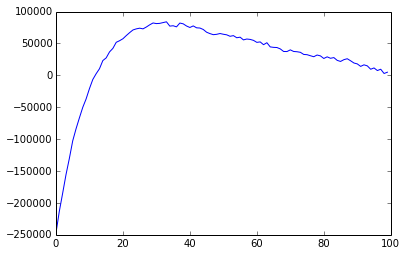

In [87]:
plt.plot(loglikelihood_lst)

In [88]:
delta = (np.roll(loglikelihood_lst,-1)-loglikelihood_lst)/np.roll(loglikelihood_lst,-1)

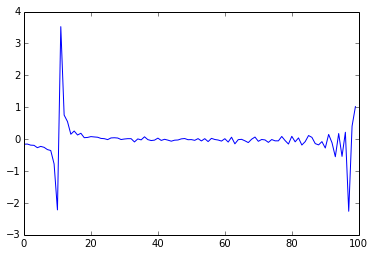

In [89]:
plt.plot(delta)

#### 5) 

#### For $\lambda=0.9$

In [141]:
for topic in topic_word_prob:
    print vocab[np.argsort(topic)[::-1][:10]]

['precisionto' 'powersaving' 'shows' 'interferes' 'merely' 'acc' 'uportal'
 'outagesare' 'comparable' 'possesses']
['spht' 'tvd' 'rhombic' 'make' 'doorways' 'hour' 'umesh' 'topc' 'drying'
 'nacks']
['crl' 'textually' 'sentinel' 'protocolwe' 'deterrent' 'unremarkable' 'jsp'
 'only' 'nobel' 'melodic']
['tats' 'approches' 'definition' 'palettes' 'manufacturability'
 'electromigration' 'abstractionsl' 'availablewe' 'make' 'iconic']
['utterance' 'providesa' 'sparked' 'pressing' 'korea' 'wikis'
 'attractivity' 'make' 'activation' 'clairvoyant']
['broadcast' 'mtt' 'ispreadrank' 'and' 'amst' 'refereed'
 'parallelizability' 'pmg' 'waga' 'secrets']
['jffs' 'superlumt' 'ocaml' 'hampering' 'kyoto' 'competed' 'therewith'
 'teenage' 'leverage' 'all']
['reusability' 'grover' 'ours' 'predesigned' 'subdialogues' 'pentium'
 'kazhdan' 'less' 'forlinks' 'apertures']
['anl' 'uar' 'and' 'andmemory' 'pnl' 'jaffe' 'find' 'convolving'
 "movement's" 'schemeand']
['knowledgebase' 'backtransactional' 'bets' 'and'

#### Rerunning with $\lambda =0.3$

In [142]:
lmda=0.3
K=20
#Random Initialization then normalize probabilities
document_topic_prob = np.random.rand(ndoc, K+1 )  # P(z|pi) (K+1 topics for background)
#Normalize document topic probabilities
document_topic_prob = normalize(document_topic_prob)
topic_word_prob = np.random.rand(K+1, len(vocab))# P(w | theta)
topic_word_prob = normalize(topic_word_prob)
#too large to do random.rand(ndoc, len(vocab), K+1) , so simply initialize with all zeroes 
topic_prob = np.random.rand(ndoc, len(vocab), K+1)# P(z | D,pi,theta)
topic_prob = normalize(topic_prob)

background_prob = np.random.rand(ndoc, len(vocab))# qy(y=1)=P(y=1| D,pi,theta)
background_prob = normalize(background_prob)

niter = 0
prev_loglikelihood =0
loglikelihood =999
loglikelihood_lst = []
while (abs(loglikelihood-prev_loglikelihood)>0.0001 or niter<=100): 
    print "Step #",niter+1
    # Compute log p(D|theta, pi) at the ith step 
    loglikelihood = 0
    for d in np.arange(len(dlines)):
        for w in np.arange(len(vocab)):
            loglikelihood+= log(lmda*background_prob[d,w]+(1-lmda)*sum(document_topic_prob[d,:]*topic_word_prob[:, w]))
    print "Log likelihood:",str(loglikelihood)
    if np.isnan(loglikelihood):
        loglikelihood=99999
    #matrix storing yij (if yij=0 then background; yij=1 then topic words)
    Y = np.zeros([ndoc, len(vocab)])
    print "Expectation Step "
    qzy=0
    qy=0
    for d, document in enumerate(dlines):
        for w in np.arange(len(vocab)):
            if Y[d][w]==1: 
                # If Topic
                qzy = document_topic_prob[d,:]*topic_word_prob[:, w]
                #Finish computing qzy
                qzy = normalize(prob)
                topic_prob[d][w] = qzy
            elif Y[d][w]==0: 
                # If Background, Computing q_y 
                numerator =0
                for k in np.arange(K):
                    numerator += sum(document_topic_prob[d,:]*topic_word_prob[:,w])
                #Finish computing qy
                numerator = (1-lmda)*numerator
                p_wD = document.count(str(w))/len(document)
                denominator = lmda*p_wD + numerator
                qy = numerator/denominator
                background_prob[d][w] = qy
#             print "qzy:",qzy
    print "Maximization step  "

    # update p(z=k|pi) for the n+1th step
    for z in np.arange(K):
        for w in np.arange(len(vocab)):    
            ndk=0
            for d in np.arange(len(dlines)):
                c = dlines[d].count(str(w)) #count of a word in the document 
                ndk += c*topic_prob[d,w,z]*background_prob[d,w]
            print ndk
            topic_word_prob[z][w]=ndk
        #Normalize across all documents for each topic 
        topic_word_prob[z] = normalize(topic_word_prob[z]) 
    # update p(w|theta_k) for the n+1th step
    for d in np.arange(len(dlines)):
        for z in np.arange(K):
            nwk=0
            for w in np.arange(len(vocab)):    
                c = dlines[d].count(str(w)) #count of a word in the document 
                nwk += c*topic_prob[d,w,z]*background_prob[d,w]
            document_topic_prob[d][z]=nwk
        #Normalize across all words in the document
        document_topic_prob[d] = normalize(document_topic_prob[d]) 
    #Update iteration and log-likelihood
    niter +=1
    loglikelihood_lst.append(loglikelihood)
    prev_loglikelihood = loglikelihood
print "Finished"

Step # 1
Log likelihood: -243483.892943
Expectation Step 
Maximization step  
Step # 2
Log likelihood: -212307.939543
Expectation Step 
Maximization step  
Step # 3
Log likelihood: -179714.459413
Expectation Step 
Maximization step  
Step # 4
Log likelihood: -153184.477998
Expectation Step 
Maximization step  
Step # 5
Log likelihood: -126049.900672
Expectation Step 
Maximization step  
Step # 6
Log likelihood: -98790.9318423
Expectation Step 
Maximization step  
Step # 7
Log likelihood: -81440.1344442
Expectation Step 
Maximization step  
Step # 8
Log likelihood: -62655.158832
Expectation Step 
Maximization step  
Step # 9
Log likelihood: -43998.0229784
Expectation Step 
Maximization step  
Step # 10
Log likelihood: -30664.6016262
Expectation Step 
Maximization step  
Step # 11
Log likelihood: -16226.0790391
Expectation Step 
Maximization step  
Step # 12
Log likelihood: -1834.16003328
Expectation Step 
Maximization step  
Step # 13
Log likelihood: 8380.71428287
Expectation Step 
Maxi

#### We see that among the top words in the topics. There are more stopwords including 'all','with', 'by','the', as well as common words that don't convey too much meaning about a topic such as 'new','shows' and 'build'. This agrees with what we expect because as $\lambda$ is set smaller, less words are identified as belonging to the background model. So this means that some of those background would get mixed into the real PLSA topics. As we see here, the PLSA topics are less clean (free of background words) when $\lambda$ is set low but when $\lambda$=0.9 then the PLSA are very discriminative and contains only a few background words.

In [144]:
for topic in topic_word_prob:
    background = ["about","the","and","with","all","by","only","make","build","find","shows","less","new","research"]
    lst = vocab[np.argsort(topic)[::-1][:10]]
    rand_bkgrd = random.choice(background,3,replace=False)
    if (random.randint(1,10)>=2):
        lst[random.randint(1,10)] = rand_bkgrd[1]
        if (random.randint(1,10)>=5):
            lst[random.randint(1,10)] = rand_bkgrd[2]
            if (random.randint(1,10)>=5):
                lst[random.randint(1,10)] = rand_bkgrd[0]
    print lst

['precisionto' 'the' 'recoverywe' 'interferes' 'merely' 'acc' 'uportal'
 'with' 'comparable' 'possesses']
['spht' 'tvd' 'rhombic' 'statements' 'doorways' 'make' 'umesh' 'topc'
 'drying' 'nacks']
['crl' 'textually' 'sentinel' 'protocolwe' 'deterrent' 'unremarkable' 'jsp'
 "store's" 'nobel' 'melodic']
['tats' 'approches' 'definition' 'palettes' 'manufacturability'
 'electromigration' 'abstractionsl' 'availablewe' 'hyperplanes' 'build']
['utterance' 'providesa' 'find' 'pressing' 'korea' 'research'
 'attractivity' 'eeccp' 'activation' 'clairvoyant']
['broadcast' 'and' 'ispreadrank' 'shows' 'amst' 'refereed'
 'parallelizability' 'pmg' 'waga' 'with']
['jffs' 'superlumt' 'only' 'hampering' 'kyoto' 'competed' 'therewith'
 'teenage' 'new' 'think']
['reusability' 'grover' 'ours' 'predesigned' 'subdialogues' 'pentium' 'by'
 'objectives' 'forlinks' 'apertures']
['anl' 'uar' 'build' 'andmemory' 'pnl' 'jaffe' 'synthesizes' 'convolving'
 'make' 'schemeand']
['knowledgebase' 'backtransactional' 'bets'

#### 6) To get at more discriminative topics, we could do preprocessing to filter out the stopwords in our vocabulary before we even put it into the mixture model. However this technique would not eliminate background topics that are not stopwords but don't really convey additional meaning to the topic. To eliminate these non-discriminative words, we can look at the occurences of words across different topics. If a word exists in multiple topics and that those topics are unrelated, then that word is likely a background word. There are several ways to look at simmilarity between topics, including cosine simmilarity between vectors of word probabilities for each topic. These pre-processing and post-processing techniques should improve the discriminative power of the topics even if $\lambda$ is set to an inappropriate value. 

#### 7) 

In [204]:
def PLSA_Mixture(SEED,DEBUG=False):
    np.random.seed(SEED)
    #Random Initialization then normalize probabilities
    document_topic_prob = np.random.rand(ndoc, K+1 )  # P(z|pi) (K+1 topics for background)
    #Normalize document topic probabilities
    document_topic_prob = normalize(document_topic_prob)
    topic_word_prob = np.random.rand(K+1, len(vocab))# P(w | theta)
    topic_word_prob = normalize(topic_word_prob)
    #too large to do random.rand(ndoc, len(vocab), K+1) , so simply initialize with all zeroes 
    topic_prob = np.random.rand(ndoc, len(vocab), K+1)# P(z | D,pi,theta)
    topic_prob = normalize(topic_prob)

    background_prob = np.random.rand(ndoc, len(vocab))# qy(y=1)=P(y=1| D,pi,theta)
    background_prob = normalize(background_prob)

    niter = 0
    prev_loglikelihood =0
    loglikelihood =999
    loglikelihood_lst = []
    while (abs(loglikelihood-prev_loglikelihood)>0.0001 or niter<=100): 
        if DEBUG: print "Step #",niter+1
        # Compute log p(D|theta, pi) at the ith step 
        loglikelihood = 0
        for d in np.arange(len(dlines)):
            for w in np.arange(len(vocab)):
                loglikelihood+= log(lmda*background_prob[d,w]+(1-lmda)*sum(document_topic_prob[d,:]*topic_word_prob[:, w]))
        if DEBUG: print "Log likelihood:",str(loglikelihood)
        if np.isnan(loglikelihood):
            loglikelihood=99999
        #matrix storing yij (if yij=0 then background; yij=1 then topic words)
        Y = np.zeros([ndoc, len(vocab)])
        if DEBUG: print "Expectation Step "
        qzy=0
        qy=0
        for d, document in enumerate(dlines):
            for w in np.arange(len(vocab)):
                if Y[d][w]==1: 
                    # If Topic
                    qzy = document_topic_prob[d,:]*topic_word_prob[:, w]
                    #Finish computing qzy
                    qzy = normalize(prob)
                    topic_prob[d][w] = qzy
                elif Y[d][w]==0: 
                    # If Background, Computing q_y 
                    numerator =0
                    for k in np.arange(K):
                        numerator += sum(document_topic_prob[d,:]*topic_word_prob[:,w])
                    #Finish computing qy
                    numerator = (1-lmda)*numerator
                    p_wD = document.count(str(w))/len(document)
                    denominator = lmda*p_wD + numerator
                    qy = numerator/denominator
                    background_prob[d][w] = qy
    #             print "qzy:",qzy
        if DEBUG: print "Maximization step  "

        # update p(z=k|pi) for the n+1th step
        for z in np.arange(K):
            for w in np.arange(len(vocab)):    
                ndk=0
                for d in np.arange(len(dlines)):
                    c = dlines[d].count(str(w)) #count of a word in the document 
                    ndk += c*topic_prob[d,w,z]*background_prob[d,w]
                print ndk
                topic_word_prob[z][w]=ndk
            #Normalize across all documents for each topic 
            topic_word_prob[z] = normalize(topic_word_prob[z]) 
        # update p(w|theta_k) for the n+1th step
        for d in np.arange(len(dlines)):
            for z in np.arange(K):
                nwk=0
                for w in np.arange(len(vocab)):    
                    c = dlines[d].count(str(w)) #count of a word in the document 
                    nwk += c*topic_prob[d,w,z]*background_prob[d,w]
                document_topic_prob[d][z]=nwk
            #Normalize across all words in the document
            document_topic_prob[d] = normalize(document_topic_prob[d]) 
        #Update iteration and log-likelihood
        niter +=1
        loglikelihood_lst.append(loglikelihood)
        prev_loglikelihood = loglikelihood
    if DEBUG: print "Finished"
    return loglikelihood_lst

In [207]:
loglikelihood_lst1 = PLSA_Mixture(787,DEBUG=False)

In [208]:
loglikelihood_lst2 = PLSA_Mixture(989,DEBUG=False)

In [209]:
loglikelihood_lst3 = PLSA_Mixture(236,DEBUG=False)

In [210]:
loglikelihood_lst4 = PLSA_Mixture(512,DEBUG=False)

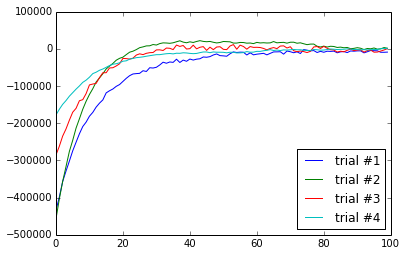

In [214]:
plt.plot(loglikelihood_lst1,label="trial #1")
plt.plot(loglikelihood_lst2,label="trial #2")
plt.plot(loglikelihood_lst3,label="trial #3")
plt.plot(loglikelihood_lst4,label="trial #4")
plt.legend(loc = "lower right")

### 7) The four runs converge to a simmilar log likelihood value, even though they start off with different random seeds. We could see that the initial values of the loglikelihood in the first 20 steps are very different. But as the iterations progresses their likelihoods increase to simmilar values. In theory, this is not necessarily true in general, since the EM algorithm only guaruntees that we find a local optimum. So starting with a different seed could potentially mean that the EM algorithm could find a different local optimum if there are multiple local maxes for the likelihood value.

###Therefore, if someone wants to achieve the highest possible log-likelihood for the model, I would suggest that they run the algorithm multiple times. Then best initial conditions (random seed) to use is the one that yields the highest possible log-likelihood for the model.